# Manejo de Tablas
Para este ejercicio se proporcionan 5  tablas referentes a una compañía de teléfonos (ofrecen 2 planes distintos) y 500 de sus usuarios. 
Cada una  contiene distintos datos, tales como la información de los usuarios, de los planes, mensajes enviados, MB utilizados (internet) y llamadas hechas. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb as dk
import pandas as pd

Cargamos las 5 tablas a un pandas Dataframe

In [2]:
calls = pd.read_csv('C:\CODE\Python\Py_Aleph\data\Problema 3. TablasCompaniaTel\megaline_calls.csv', sep = ',')
internet = pd.read_csv('C:\CODE\Python\Py_Aleph\data\Problema 3. TablasCompaniaTel\megaline_internet.csv', sep = ',')
sms = pd.read_csv('C:\CODE\Python\Py_Aleph\data\Problema 3. TablasCompaniaTel\megaline_messages.csv', sep = ',')
plans = pd.read_csv('C:\CODE\Python\Py_Aleph\data\Problema 3. TablasCompaniaTel\megaline_plans.csv', sep =',')
users = pd.read_csv('C:\CODE\Python\Py_Aleph\data\Problema 3. TablasCompaniaTel\megaline_users.csv', sep = ',')

1. ¿Cuál es la edad promedio de los usuarios del plan "surf"? Por otra parte, incluye el diagrama de caja y bigotes de la edad de los usuarios que utilizan el plan premium.

Este problema se puede solucionar de una manera muy sencilla a partir de un consulta SQL 

In [3]:
query_1 = '''
SELECT age 
FROM users 
WHERE plan='surf';'''

age_array = dk.query(query_1).df()

print('edad promedio de usuarios con plan surf es', np.mean(age_array))

edad promedio de usuarios con plan surf es 44.95280235988201


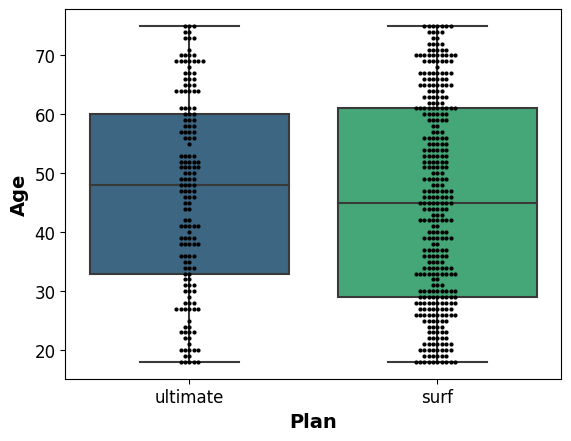

In [4]:
query_1 = '''
SELECT age, plan 
FROM users;'''
age_array = dk.query(query_1).df()

sns.boxplot(x='plan', y='age', data=age_array, palette='viridis')
sns.swarmplot(x='plan', y='age', data=age_array, color='black', size=3)
plt.xlabel('Plan', fontsize=14, fontweight='bold')
plt.ylabel('Age', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

2. ¿Cuáles son los ingresos que percibió la empresa en el periodo de los datos que se tienen?

El conjunto de datos es del año 2018 por lo tanto solo se consideran ganancia durante ese año, añadido a esto hacemos una consulta SQL y calculamos cuantos meses un usuario ha usado su plan y lo multiplicamos por el costo mensual de su plan, esto asumiendo que ningun usuario puede sobrepasar el limite de minutos, Mb y mensajes, sin embargo con una mayor información de como se manejan este tipo de exesos el conteo debe de ser distinto, la aproximacion que se da es una ganancia base de la empresa


In [5]:
query_2 = '''
SELECT user_id, plan, reg_date, churn_date
FROM users;
'''

profit = dk.query(query_2).df()
profit['reg_date'] = pd.to_datetime(profit['reg_date'], format='%Y-%m-%d')
profit['churn_date'] = pd.to_datetime(profit['churn_date'], format='%Y-%m-%d', errors='coerce')
profit['churn_date'] = profit['churn_date'].fillna(pd.Timestamp('2018-12-31'))

profit['months_used'] = (profit['churn_date'].dt.year - profit['reg_date'].dt.year) * 12 + (profit['churn_date'].dt.month - profit['reg_date'].dt.month + 1)

monthly_pay = {'surf': 20, 'ultimate': 70}
profit['profit_generated'] = profit['months_used'] * profit['plan'].map(monthly_pay)
profit_summary = profit['profit_generated'].sum()

print(profit_summary)

119810


3. ¿En qué rango de edad se utilizan más MB (internet)? Define los rangos en los que crees conveniente separar los datos y por qué. 

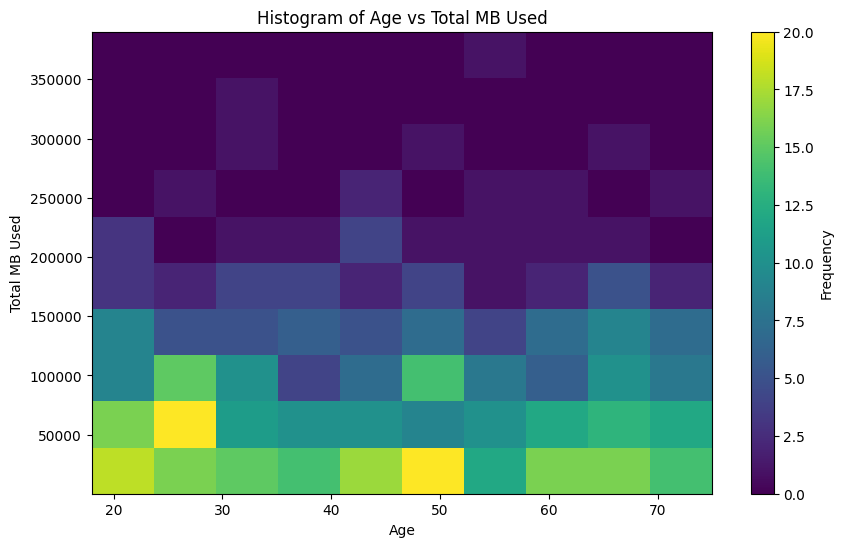

In [6]:
query_3 = '''
SELECT u.user_id, u.age, q.total_mb_used
FROM users AS u
JOIN (
    SELECT user_id, SUM(mb_used) AS total_mb_used
    FROM internet
    GROUP BY user_id
) AS q
ON u.user_id = q.user_id;
'''

data = dk.query(query_3).df()

plt.figure(figsize=(10, 6)) 
plt.hist2d(data['age'], data['total_mb_used'], cmap='viridis')
plt.xlabel('Age')
plt.ylabel('Total MB Used')
plt.title('Histogram of Age vs Total MB Used')
plt.colorbar(label='Frequency')
plt.show()

Se definien los rangos de acuerdo a la grafica enaterior de la siguiente forma
- menos de 30 años
- de 30 a 40 años
- de 40 a 60 años
- de 60 años en adelante

se tiene la hipotesis que los adultos entre 30 y 60 años son los que utilizan una mayor cantidad de MB esto debido a la actividad cotidiana, donde se plantea que es mas ajetreada que la de los jovenes y que la de los adultos mayores 

In [7]:
age_ranges = {
    'menos de 30 años': (0, 30),
    'de 30 a 40 años': (30, 41),
    'de 40 a 60 años': (40, 61),
    'de 60 años en adelante': (60, float('inf'))
}

mean_mb_used = {}

for label, (lower, upper) in age_ranges.items():
    subset = data[(data['age'] >= lower) & (data['age'] < upper)]
    mean_mb_used[label] = subset['total_mb_used'].mean()
    
print("Mean Mb_used for each age range:")

for label, mean in mean_mb_used.items():
    print(f"{label}: {mean}")

Mean Mb_used for each age range:
menos de 30 años: 74427.64384615385
de 30 a 40 años: 81427.46356321839
de 40 a 60 años: 81274.78207100592
de 60 años en adelante: 78036.07335877862


4. Obten el histograma de la duración de llamadas (también hazlo por rangos). Después, obtén una gráfica de barras de dos factores, considerando la duración de llamadas y las edades de los usuarios (recuerda, usa rangos para ambas). 

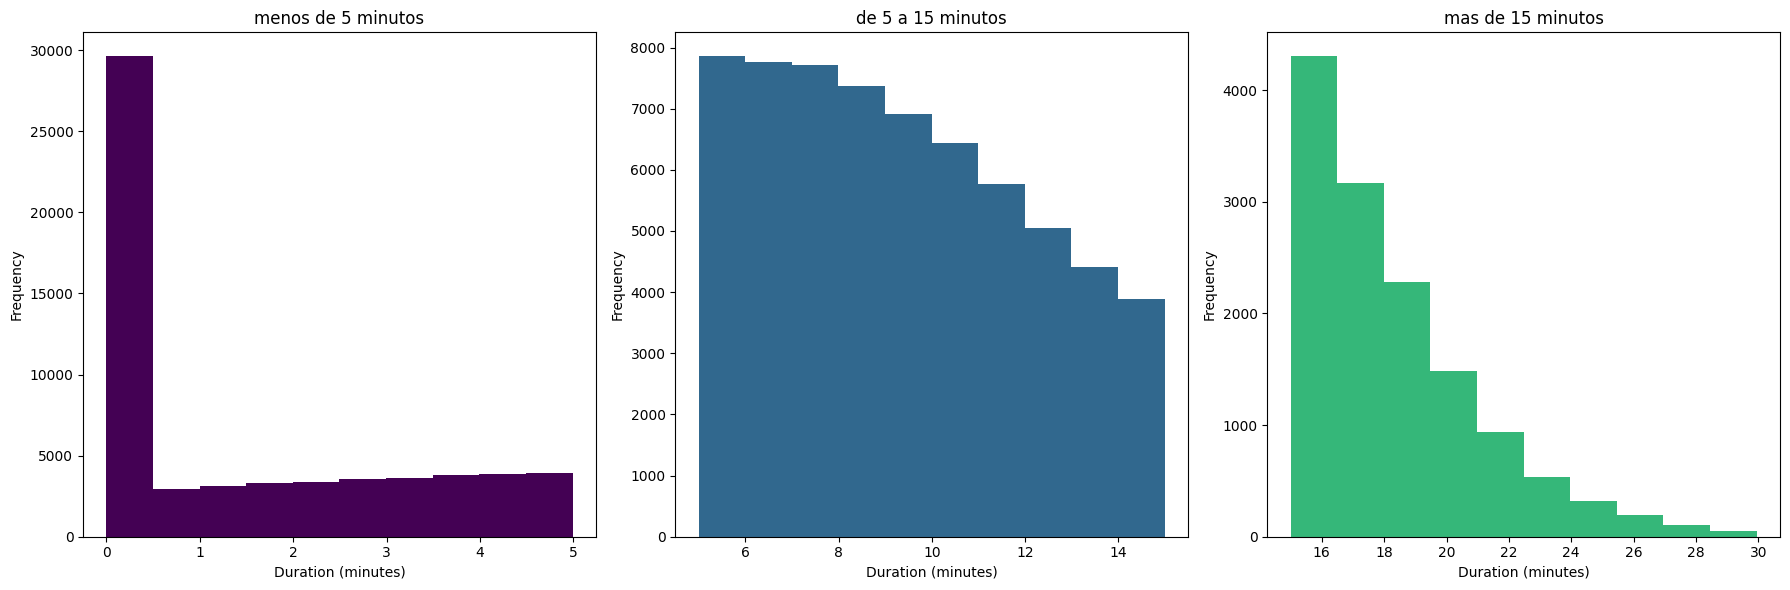

In [8]:
query_4 = '''
SELECT u.user_id, u.age, c.duration
FROM users as u, calls as c
WHERE u.user_id = c.user_id;
'''
call_duration = dk.query(query_4).df()
call_ranges = {
    'menos de 5 minutos': (0, 5),
    'de 5 a 15 minutos': (5, 15),
    'mas de 15 minutos': (15, 30)
}
age_ranges = {
    'menos de 30 años': (0, 30),
    'de 30 a 40 años': (30, 41),
    'de 40 a 60 años': (40, 61),
    'de 60 años en adelante': (60,100)
}

palette = ['#440154', '#31688e', '#35b779'] 
fig, axes = plt.subplots(1, 3, figsize=(18, 6))


for ax, (label, (lower, upper)), palette in zip(axes, call_ranges.items(), palette):
    subset = call_duration[(call_duration['duration'] >= lower) & (call_duration['duration'] < upper)]
    bins = range(int(lower), int(upper) + 1)
    ax.hist(subset['duration'], color=palette)
    ax.set_title(label)
    ax.set_xlabel('Duration (minutes)')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

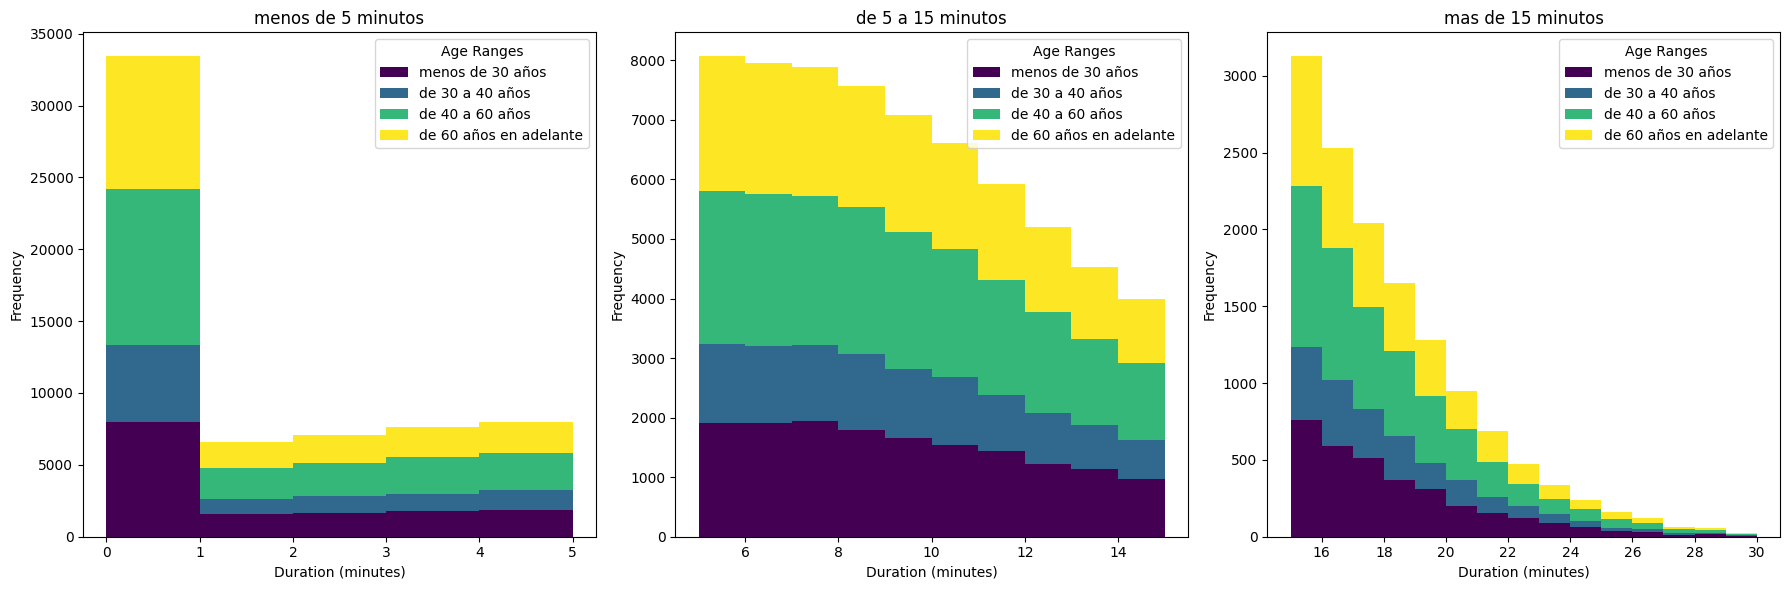

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
palette = ['#3b528b', '#21918c', '#5ec962']
colors = ['#440154', '#31688e', '#35b779', '#fde725'] 

for ax, (label, (lower, upper)), base_color in zip(axes, call_ranges.items(), palette):
    subset = call_duration[(call_duration['duration'] >= lower) & (call_duration['duration'] < upper)]
    bins = range(int(lower), int(upper) + 1)
    bottom_array = None 
    for age_label, (age_lower, age_upper), color in zip(age_ranges.keys(), age_ranges.values(), colors):
        age_subset = subset[(subset['age'] >= age_lower) & (subset['age'] < age_upper)]
        values, bins = np.histogram(age_subset['duration'], bins=bins)
        ax.bar(bins[:-1], values, bottom=bottom_array, width=np.diff(bins), label=age_label, color=color, align='edge')
        if bottom_array is None:
            bottom_array = values
        else:
            bottom_array = bottom_array + values

    ax.set_title(label)
    ax.set_xlabel('Duration (minutes)')
    ax.set_ylabel('Frequency')
    ax.legend(title='Age Ranges')

plt.tight_layout()
plt.show()

5. ¿Cuál es el promedio de MB utilizados por mes en cada uno de los planes? 

Primero convertimos a fecha el CSV de internet para poder hacer interpretación de los datos

In [10]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['year'] = internet['session_date'].dt.year
internet['month'] = internet['session_date'].dt.month
internet['day'] = internet['session_date'].dt.day
internet.head()

,id,user_id,session_date,mb_used,year,month,day
0,1000_13,1000,2018-12-29,89.86,2018,12,29
1,1000_204,1000,2018-12-31,0.00,2018,12,31
2,1000_379,1000,2018-12-28,660.40,2018,12,28
3,1000_413,1000,2018-12-26,270.99,2018,12,26
4,1000_442,1000,2018-12-27,880.22,2018,12,27


Bajo esta estructura de tiempo en el nuevo dataset, utilizamos una consulta SQL para agrupar los meses y planes 

In [11]:
query_5 = ''' 
SELECT u.plan, MONTH(i.session_date) AS month, AVG(i.mb_used) AS Mean_mb_per_plan
FROM users AS u
JOIN internet AS i ON u.user_id = i.user_id
GROUP BY u.plan, MONTH(i.session_date)
ORDER BY u.plan, MONTH(i.session_date);
'''

months = dk.query(query_5).df()
months.head(30)

,plan,month,Mean_mb_per_plan
0,surf,1,324.990667
1,surf,2,355.875292
2,surf,3,374.780366
3,surf,4,360.752649
4,surf,5,359.136322
5,surf,6,357.391844
6,surf,7,369.172091
7,surf,8,370.889269
8,surf,9,364.440406
9,surf,10,365.471799


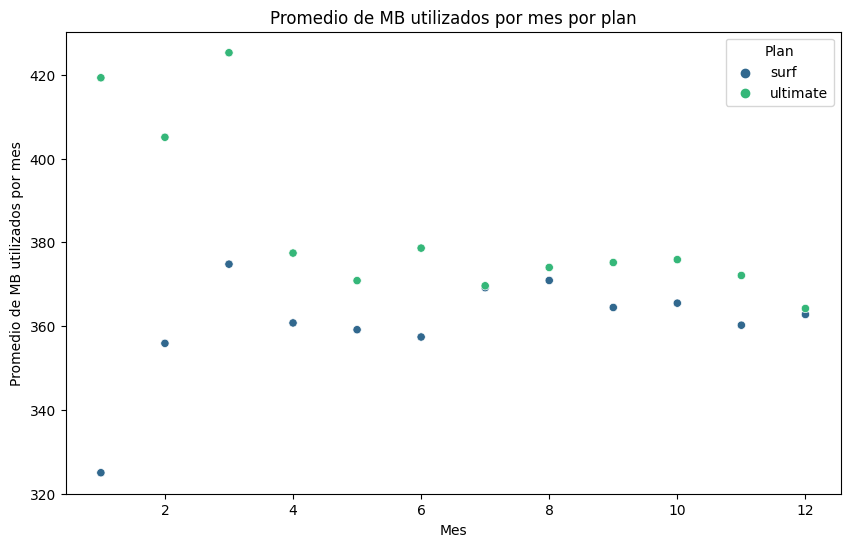

In [12]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=months, x='month', y='Mean_mb_per_plan', hue='plan', palette='viridis')
plt.title('Promedio de MB utilizados por mes por plan')
plt.xlabel('Mes')
plt.ylabel('Promedio de MB utilizados por mes')
plt.legend(title='Plan')
plt.show()

6. Programa una función para que puedas obtener un resumen de cada usuario: cuál plan utiliza, cuántas llamadas realizó, cuántos MB utilizó y cuántos mensajes envió. 

Se plantea una consulta SQL utilizando Joins para asociar con cas usuario su suma de mensajes, llemadas y MB's para todos los usuarios, adicionalmente se usa parte del codigo utilizado en el problema 2 donde se calculan las ganancias de la empresa para calcular el tiempo en meses que el usuario lleva usando su plan

In [13]:
query_6 = ''' 
SELECT 
    u.user_id, 
    u.plan, 
    r.total_mb, 
    IFNULL(c.total_calls, 0) AS total_calls, 
    IFNULL(s.total_messages, 0) AS total_messages,
    u.reg_date,
    u.churn_date
    
FROM 
    users AS u 
LEFT JOIN (
    SELECT 
        user_id, 
        SUM(mb_used) AS total_mb
    FROM 
        internet
    GROUP BY 
        user_id
) AS r ON u.user_id = r.user_id
LEFT JOIN (
    SELECT 
        user_id, 
        COUNT(*) AS total_calls
    FROM 
        calls
    GROUP BY 
        user_id
) AS c ON u.user_id = c.user_id
LEFT JOIN (
    SELECT 
        user_id, 
        COUNT(*) AS total_messages
    FROM 
        sms
    GROUP BY 
        user_id
) AS s ON u.user_id = s.user_id;
'''

user_resume = dk.query(query_6).df()
user_resume = user_resume.sort_values(by='user_id')
user_resume['reg_date'] = pd.to_datetime(user_resume['reg_date'], format='%Y-%m-%d')
user_resume['churn_date'] = pd.to_datetime(user_resume['churn_date'], format='%Y-%m-%d', errors='coerce')
user_resume['churn_date'] = user_resume['churn_date'].fillna(pd.Timestamp('2018-12-31'))

user_resume['months_used'] = (user_resume['churn_date'].dt.year - user_resume['reg_date'].dt.year) * 12 + (user_resume['churn_date'].dt.month - user_resume['reg_date'].dt.month + 1)
user_resume.head()

,user_id,plan,total_mb,total_calls,total_messages,reg_date,churn_date,months_used
237,1000,ultimate,1901.47,16,11,2018-12-24,2018-12-31,1
0,1001,surf,80437.94,261,207,2018-08-13,2018-12-31,5
351,1002,surf,40293.33,113,88,2018-10-21,2018-12-31,3
352,1003,surf,27044.14,149,50,2018-01-28,2018-12-31,12
123,1004,surf,156352.81,370,177,2018-05-23,2018-12-31,8


7. Utiliza la función del inciso 6 para calcular el resumen de 5 usuarios y evalúa si están aprovechando su plan o les conviene cambiarse al otro. Argumenta por qué. 

utilizamos la tabla generada en el inciso anterior para obtener el resumen de 5 usuarios, filtramos dicha tabla mediante un array con id's lo cual debuelve un subset para analizar 

In [14]:
ids = [1000,1001, 1002,1003,1004]
user_analisis = user_resume[user_resume['user_id'].isin(ids)]

user_analisis.head()

,user_id,plan,total_mb,total_calls,total_messages,reg_date,churn_date,months_used
237,1000,ultimate,1901.47,16,11,2018-12-24,2018-12-31,1
0,1001,surf,80437.94,261,207,2018-08-13,2018-12-31,5
351,1002,surf,40293.33,113,88,2018-10-21,2018-12-31,3
352,1003,surf,27044.14,149,50,2018-01-28,2018-12-31,12
123,1004,surf,156352.81,370,177,2018-05-23,2018-12-31,8


Analizamos a los primeros 5 usuarios

para el usuario con id 1000 que tiene escasos dias con el plan por lo que no se tiene suficiente información para realizar un analisis considerable el plan ultimate es mas costozo que el plan surf por lo que entre menos use el plan ultimate esto representa una ganancia mayor para la empresa


para el usuario 1001 el promedio de uso mensual de mb supera levemente el limete mesual permitido al igual que el total de mansajes esto (segun mi interpretacion) el cargo extra a la cuota mensual ocasionalmente se ve levemente aumentada mantener el plan y pagar el extra 

para el usuario 1002 el promedio mensual de mb no supera el limete del plan al igual que el numero de mensajes por lo que el uso que se le esta dando al plan es suficiente

para el usuario 1003 el promedio de mb usados por mes es de 2253 el usuario no esta aprovechando completamente su plan, queda un gran marjen de uso del plan sin embargo dado que no existe un plan mas sencillo es necesaria la utilizacion de este

para el usuario 1004 con un promedio de uso de mb mensual de 19544 supera por mucho lo que el plan surf puede ofrecer y se sugiere cambio al plan ultimate, sin embargo la diferencia de precios entre el surf y el ultimate es de 3.5 veces por lo que no pareciera tan rentable el hecho de cambiarse.

8. Suponiendo que el plan que contratan las personas revela información relevante sobre su nivel socioeconómico, y asumiendo que se tiene una muestra representativa:  ¿Qué ciudad tiene mejores condiciones de vida? 

In [15]:
query_8 = ''' 
SELECT 
    city,
    SUM(CASE WHEN plan = 'surf' THEN 1 ELSE 0 END) AS surf_users_count,
    SUM(CASE WHEN plan = 'ultimate' THEN 1 ELSE 0 END) AS ultimate_users_count
FROM 
    users
GROUP BY 
    city
ORDER BY ultimate_users_count DESC;
'''


city_resume = dk.query(query_8).df()
city_resume.head(10)

,city,surf_users_count,ultimate_users_count
0,"New York-Newark-Jersey City, NY-NJ-PA MSA",60.0,20.0
1,"Los Angeles-Long Beach-Anaheim, CA MSA",18.0,11.0
2,"Atlanta-Sandy Springs-Roswell, GA MSA",6.0,8.0
3,"Chicago-Naperville-Elgin, IL-IN-WI MSA",11.0,8.0
4,"San Francisco-Oakland-Berkeley, CA MSA",4.0,7.0
5,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",11.0,6.0
6,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",5.0,6.0
7,"Minneapolis-St. Paul-Bloomington, MN-WI MSA",6.0,5.0
8,"Seattle-Tacoma-Bellevue, WA MSA",9.0,4.0
9,"San Antonio-New Braunfels, TX MSA",2.0,4.0


Suponiendo que a mayor numero de usuarios ultimate mejor calidad de vida se muestran las 10 ciudades con mas usuarios ultimate y concuerda con ser de las ciudades mas importantes de EUA siendo New York, Los Angeles, Atlanta, Chicago, San Francisco, Philadelphia, Miami, Minneapolis, Las Vegas y Huston

ahora si suponemos que a una mayor porcentaje de usuarios ultimate refleja mejor condicion de vida obtenemos lo siguiente

In [17]:
city_resume['total_users'] = city_resume['surf_users_count'] + city_resume['ultimate_users_count']
city_resume['surf_users_percentage'] = (city_resume['surf_users_count'] / city_resume['total_users']) * 100
city_resume['ultimate_users_percentage'] = (city_resume['ultimate_users_count'] / city_resume['total_users']) * 100
city_resume = city_resume.sort_values(by='ultimate_users_percentage', ascending=False)
city_resume.head(10)

,city,surf_users_count,ultimate_users_count,total_users,surf_users_percentage,ultimate_users_percentage
44,"Cape Coral-Fort Myers, FL MSA",0.0,1.0,1.0,0.000000,100.000000
15,"Charleston-North Charleston, SC MSA",0.0,3.0,3.0,0.000000,100.000000
17,"Virginia Beach-Norfolk-Newport News, VA-NC MSA",1.0,3.0,4.0,25.000000,75.000000
13,"Houston-The Woodlands-Sugar Land, TX MSA",2.0,4.0,6.0,33.333333,66.666667
9,"San Antonio-New Braunfels, TX MSA",2.0,4.0,6.0,33.333333,66.666667
21,"Cleveland-Elyria, OH MSA",1.0,2.0,3.0,33.333333,66.666667
30,"Salt Lake City, UT MSA",1.0,2.0,3.0,33.333333,66.666667
28,"Tampa-St. Petersburg-Clearwater, FL MSA",1.0,2.0,3.0,33.333333,66.666667
4,"San Francisco-Oakland-Berkeley, CA MSA",4.0,7.0,11.0,36.363636,63.636364
20,"Knoxville, TN MSA",2.0,3.0,5.0,40.000000,60.000000
